# 패키지 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 하이퍼 파라미터 설정

In [2]:
PAST = 12
SPLIT = 0.8
NEURON = 500
RNN_SHAPE = (PAST, 1)
EPOCH = 100
BATCH = 64

# 데이터 로딩 및 스케일링

In [16]:
df = pd.read_csv('airline.csv', header=None)
print(df.shape)
display(df.head())

(144, 2)


,0,1
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [17]:
df = df[[1]]

In [18]:
display(df.head())

,1
0,112
1,118
2,132
3,129
4,121


In [19]:
raw_DB = np.array(df).astype(float)
# print(raw_DB.flatten())
scaler = MinMaxScaler()  # 정규화
raw_DB = scaler.fit_transform(raw_DB)
print(raw_DB.flatten())

[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734
 0.34749035 0.33397683 0.41119691 0.4034749  0.41312741 0.5212

# Time Step 데이터 생성 및 학습/평가 데이터 분할

In [22]:
data = [] 
for i in range(len(raw_DB) - PAST):
    data.append(raw_DB[i:i+PAST+1])  # 1st: 0~12, 2nd: 1~13, 3rd: 2~14 오른쪽으로 1칸씩 이동하며 13개 데이터 끊어서 가져옴

reshaped_data = np.array(data)

In [25]:
print(reshaped_data.shape)
np.random.shuffle(reshaped_data)
print(reshaped_data[0])  # 앞의 12개 = 독립변수 입력값, 마지막 값 = 종속변수 y (결과값)

(132, 13, 1)
[[0.24131274]
 [0.26640927]
 [0.24903475]
 [0.31467181]
 [0.31853282]
 [0.32046332]
 [0.40733591]
 [0.5019305 ]
 [0.46911197]
 [0.4015444 ]
 [0.32818533]
 [0.25675676]
 [0.33590734]]


- 입력 값과 출력 값으로 분리
>- 인덱스 0~11 (12 months)를 입력 값으로 사용
>- 12번째 인덱스를 출력 값으로 사용

In [26]:
x_data = reshaped_data[:, :PAST]
y_data = reshaped_data[:, -1]

split_boundary = int(reshaped_data.shape[0] * SPLIT)
x_train = x_data[:split_boundary]
x_test = x_data[split_boundary:]
y_train = y_data[:split_boundary]
y_test = y_data[split_boundary:]

In [27]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (105, 12, 1)
x_test shape: (27, 12, 1)
y_train shape: (105, 1)
y_test shape: (27, 1)


# 모델 생성

- LSTM(unit, input_shape=(time_step, feature))
>- unit: hidden state의 크기, 임의의 개수 설정
>- time_step: 과거 몇 개의 데이터를 학습할 것인지 설정
>- feature: 입력값 x의 차원 (여행객 수만 고려하기 때문에 특성 차원 수는 1)

In [29]:
model = Sequential()
model.add(LSTM(units=NEURON, input_shape=RNN_SHAPE))
model.add(Dense(units=NEURON, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 500)                 │       1,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,255,001 (4.79 MB)

 Trainable params: 1,255,001 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, verbose=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.1369 - mae: 0.3028
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0243 - mae: 0.1058
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0137 - mae: 0.0945
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0232 - mae: 0.1042
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0229 - mae: 0.1070
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0106 - mae: 0.0752
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0146 - mae: 0.1015
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0112 - mae: 0.0868
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0099 - mae: 0.0702
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0123 - mae: 0.0734
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0105 - mae: 0.0681
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0090 - mae: 0.0697
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


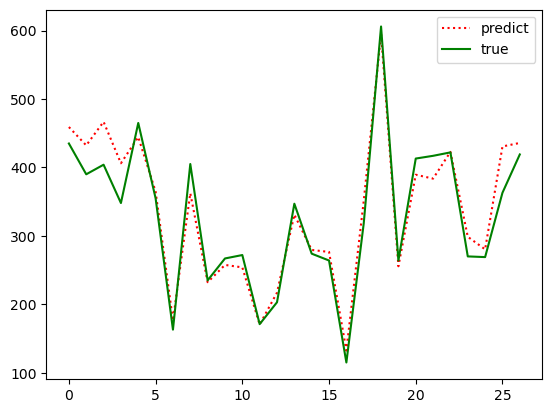

In [32]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform(y_test)

plt.plot(pred, 'r:', label='predict')
plt.plot(y_test, 'g-', label='true')
plt.legend()
plt.show()